In [61]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [25]:
train_df = pd.read_csv('data/train.csv')
val_df = pd.read_csv('data/val.csv')

train_df["image:FILE"] = "data/" + train_df["image:FILE"]
val_df["image:FILE"] = "data/" + val_df["image:FILE"]

train_df.sample(5)

,image:FILE,category
913,data/train/bean_rust/bean_rust_train.132.jpg,2
826,data/train/bean_rust/bean_rust_train.28.jpg,2
326,data/train/healthy/healthy_train.113.jpg,0
556,data/train/angular_leaf_spot/angular_leaf_spot...,1
607,data/train/angular_leaf_spot/angular_leaf_spot...,1


In [26]:
train_df["category"].unique()

array([0, 1, 2])

In [27]:
print(f"Train set size: {len(train_df)} \n Validation set size: {len(val_df)}")

Train set size: 1034 
 Validation set size: 133


In [28]:
print(train_df["category"].value_counts())

category
2    348
1    345
0    341
Name: count, dtype: int64


In [40]:
label_encoder = LabelEncoder()

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [42]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.labels = torch.tensor(label_encoder.fit_transform(df['category'])).to(device)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)/255.0

        return image, label

In [43]:
train_dataset = CustomImageDataset(df=train_df, transform=transform)
val_dataset = CustomImageDataset(df=val_df, transform=transform)

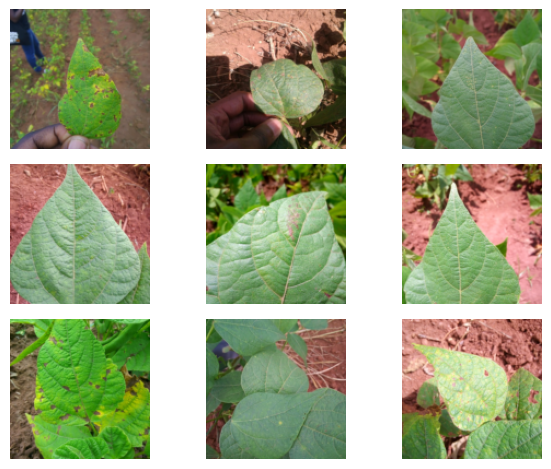

In [46]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
        image = train_dataset[np.random.randint(0,train_dataset.__len__())][0].cpu()
        axarr[row, col].imshow((image*255).squeeze().permute(1,2,0))
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

In [47]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15

In [48]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [49]:
googlenet_model = models.googlenet(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\user/.cache\torch\hub\checkpoints\googlenet-1378be20.pth


100.0%


In [50]:
for param in googlenet_model.parameters():
    param.requires_grad = True

In [51]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [52]:
num_classes = len(train_df["category"].unique())
num_classes

3

In [53]:
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [54]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [62]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr=LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
    total_loss_train = 0
    total_acc_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = googlenet_model(inputs)
        train_loss = loss_fun(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()

        train_acc = (torch.argmax(outputs, 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/train_df.__len__()*100, 4))
    print(f"Epoch {epoch+1}/{EPOCHS}\n \t Train Loss: {round(total_loss_train/1000, 4)}\n\t Train Accuracy: {round(total_acc_train/train_df.__len__()*100, 4)}%")


Epoch 1/15
 	 Train Loss: 0.2338
	 Train Accuracy: 60.3482%
Epoch 2/15
 	 Train Loss: 0.2044
	 Train Accuracy: 67.4081%
Epoch 3/15
 	 Train Loss: 0.1958
	 Train Accuracy: 67.6983%
Epoch 4/15
 	 Train Loss: 0.1834
	 Train Accuracy: 70.5029%
Epoch 5/15
 	 Train Loss: 0.1674
	 Train Accuracy: 74.8549%
Epoch 6/15
 	 Train Loss: 0.1551
	 Train Accuracy: 75.5319%
Epoch 7/15
 	 Train Loss: 0.147
	 Train Accuracy: 79.0135%
Epoch 8/15
 	 Train Loss: 0.1367
	 Train Accuracy: 80.1741%
Epoch 9/15
 	 Train Loss: 0.1267
	 Train Accuracy: 81.528%
Epoch 10/15
 	 Train Loss: 0.1285
	 Train Accuracy: 80.2708%
Epoch 11/15
 	 Train Loss: 0.1197
	 Train Accuracy: 82.5919%
Epoch 12/15
 	 Train Loss: 0.1169
	 Train Accuracy: 83.0754%
Epoch 13/15
 	 Train Loss: 0.0991
	 Train Accuracy: 85.3965%
Epoch 14/15
 	 Train Loss: 0.108
	 Train Accuracy: 84.1393%
Epoch 15/15
 	 Train Loss: 0.0852
	 Train Accuracy: 87.6209%


In [63]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for inputs, labels in val_loader:
        prediction = googlenet_model(inputs)

        acc = (torch.argmax(prediction, 1) == labels).sum().item()
        total_acc_test += acc


In [64]:
print(round(total_acc_test/val_df.__len__()*100, 4))

83.4586


### Transfer Learning

In [67]:
google_net_model = models.googlenet(weights='DEFAULT')

for param in google_net_model.parameters():
    param.requires_grad = False

google_net_model.fc = torch.nn.Linear(google_net_model.fc.in_features, num_classes)
google_net_model.fc.requires_grad = True
google_net_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [68]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(google_net_model.parameters(), lr=LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
    total_loss_train = 0
    total_acc_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = google_net_model(inputs)
        train_loss = loss_fun(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()

        train_acc = (torch.argmax(outputs, 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/train_df.__len__()*100, 4))
    print(f"Epoch {epoch+1}/{EPOCHS}\n \t Train Loss: {round(total_loss_train/1000, 4)}\n\t Train Accuracy: {round(total_acc_train/train_df.__len__()*100, 4)}%")


Epoch 1/15
 	 Train Loss: 0.2725
	 Train Accuracy: 45.1644%
Epoch 2/15
 	 Train Loss: 0.2376
	 Train Accuracy: 56.5764%
Epoch 3/15
 	 Train Loss: 0.239
	 Train Accuracy: 56.0928%
Epoch 4/15
 	 Train Loss: 0.2284
	 Train Accuracy: 59.2843%
Epoch 5/15
 	 Train Loss: 0.2222
	 Train Accuracy: 61.5087%
Epoch 6/15
 	 Train Loss: 0.2277
	 Train Accuracy: 60.8317%
Epoch 7/15
 	 Train Loss: 0.225
	 Train Accuracy: 60.9284%
Epoch 8/15
 	 Train Loss: 0.2159
	 Train Accuracy: 61.412%
Epoch 9/15
 	 Train Loss: 0.2228
	 Train Accuracy: 61.412%
Epoch 10/15
 	 Train Loss: 0.2116
	 Train Accuracy: 62.4758%
Epoch 11/15
 	 Train Loss: 0.2121
	 Train Accuracy: 62.5725%
Epoch 12/15
 	 Train Loss: 0.2123
	 Train Accuracy: 63.9265%
Epoch 13/15
 	 Train Loss: 0.2229
	 Train Accuracy: 62.2824%
Epoch 14/15
 	 Train Loss: 0.2208
	 Train Accuracy: 60.8317%
Epoch 15/15
 	 Train Loss: 0.2121
	 Train Accuracy: 64.8936%


In [69]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for inputs, labels in val_loader:
        prediction = google_net_model(inputs)

        acc = (torch.argmax(prediction, 1) == labels).sum().item()
        total_acc_test += acc

In [70]:
print(round(total_acc_test/val_df.__len__()*100, 4))

61.6541
